# Notebook 51: Single HR panel for one mass and all periods

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 51

## Imports

In [2]:
from pathlib import Path
from math import isnan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius
from src.util import (savefig_base, get_model_folder_base, get_model_dict, history_plot, 
                      hr_diagram_tracks_base, normarr)

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

In [4]:

FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [6]:
Z_SUN = 0.017

### Utilities

In [7]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [8]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [9]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [10]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [11]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


In [12]:
mesareader_operator('log_L/Estar_mass,^log_L,surface_h1)')

'h.__getattr__("log_L")/gamma_e(h.__getattr__("star_mass"),10**h.__getattr__("log_L"),h.__getattr__("surface_h1"))'

### Plotting

In [13]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax, handles

### Winds

In [14]:
def _sanders_winds(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1.41e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/Z_SUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/Z_SUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/Z_SUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/Z_SUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/Z_SUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [15]:
vink2001_w = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [16]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, t, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [17]:
winds = np.vectorize(_winds)

## HR diagram

In [18]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [19]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [20]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax, handles = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(0.5, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[10]-r_y[0])/(hd_x[10]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            if (x < max(xlim) and x > min(xlim)) and (y < max(ylim) and y > min(ylim)):
                ax.text(
                    x, 
                    y,
                    f'${r:.1f}\\,\\mathrm{{R}}_\\odot$',
                    rotation=rotation,
                    ha='left',
                    va='top', 
                    fontsize=6,
                    alpha=0.8
                    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    return ax, handles

In [21]:
def density_temperature_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_center_Rho',
        y='log_center_T',
        invert_xaxis=False,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log \\rho_\\mathrm{c}/\\mathrm{g}\\,\\mathrm{cm}^{-3}$')
    if labely:
        ax.set_ylabel('$\\log T_\\mathrm{c}/\\mathrm{K}$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax

In [22]:
def old_e_scattering_edd_l(m):
    m = fix_unit(m, u.Msun)
    k = 0.4 * u.cm**2 /u.g
    l = 4*np.pi*ct.c*ct.G*m/k
    l = l.to(u.Lsun)
    return l.value

In [23]:
def gamma_e(m, l, x):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 10.**-4.813 * (1+x) * l/m

In [24]:
def compas_gamma_e(m, l):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 7.66e-5 * 0.325*l/m

In [25]:
def hre_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        #y='^log_L/Estar_mass)',
        y='Estar_mass,^log_L,surface_h1)',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax, handles = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\Gamma_\\mathrm{e}$')
    
    if xlim is not None:    
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    return ax, handles

### Final properties

In [26]:
def get_core_mass_spin_w(logs, iso):
    central_iso_arr = [logs.profile_data(profile_number=n).__getattr__(iso)[-1] for n in logs.profile_numbers]
    max_iso_i = np.argmax(central_iso_arr)
    core_prof = logs.profile_data(profile_number=logs.profile_numbers[max_iso_i])
    core_edge_index = np.where(np.abs(core_prof.__getattr__(iso)-core_prof.__getattr__(iso)[-1]) <= 0.01)[0][0]
    core_mass = core_prof.mass[core_edge_index]
    core_am = 10**core_prof.log_J_inside[core_edge_index]
    core_w = core_prof.omega[core_edge_index]
    core_spin = (ct.c.cgs * core_am * u.g*u.cm**2/u.s / (ct.G.cgs * (core_mass * ct.M_sun.cgs)**2 )).to(u.dimensionless_unscaled).value
    return core_mass, core_spin, core_w

In [27]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e6:.2f} Myr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q
    
    @staticmethod
    def p_from_s(s, m):
        j = (ct.G.cgs * (m * u.Msun)**2 * s / ct.c.cgs).to(u.s).value
        return p
    
    def get_final_core_mps(self):
        core_m, core_s, core_w = get_core_mass_spin_w(self.logs, iso='o16')
        core_p = 2*np.pi/core_w * u.s.to(u.d)
        return core_m, core_p, core_s

In [28]:
def edd_gamma(x, l, m):
    return 10**-4.813 * (1+x) * l/m

def krticka2024_w(l, teff, z):
    a = -13.82
    b = 1.52
    c = 3.84
    t1 = 14.16e3
    t2 = 37.9e3
    dt1 = 3.58e3
    dt2 = 56.5e3
    alpha = 0.358
    beta = -0.11
    delta = 0.73
    log_z_div_z_sun = np.log10(z/Z_SUN)
    
    log_lin_comp = (a
                    + alpha * log_z_div_z_sun
                    + (b + beta * log_z_div_z_sun) * np.log10(l/1e6))
    gauss_mix_comp = ((1 + delta * log_z_div_z_sun) * np.exp(-(teff-t1)**2/dt1**2)
                      + c * np.exp(-(teff-t2)**2/dt2**2))
    log_mdot = log_lin_comp - a * np.log10(gauss_mix_comp)
    w = 10.**log_mdot
    return w

def bjorklund2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

def sander2023_w(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1e5)
        w = 10.**log_w
    return w

def get_g_switch(l, m, t, z, x, scheme):
    z_div_zsun = z/Z_SUN
    if scheme == 'vink':
        g_switch = 0.243 * z_div_zsun**-0.541
    elif scheme == 'krticka':
        g_switch = 0.585 * z_div_zsun**-0.016
    elif scheme == 'bjorklund':
        g_switch = 0.838 * z_div_zsun**-0.099
    elif scheme == 'bjorklund+krticka':
        k24_w = krticka2024_w(l, t, z)
        b23_w = bjorklund2023_w(l, m, t, z, x)
        if k24_w <= b23_w:
            g_switch = 0.585 * z_div_zsun**-0.016
        else:
            g_switch = 0.838 * z_div_zsun**-0.099
    return g_switch

def vink2011_winds(l, m, t, z, x, g_switch, m_switch):
    g_e = edd_gamma(x, l, m)
    v01_w = vink2001_w(l, t, m, z)
    
    if g_e < g_switch:
        w = v01_w
    else:
        w = v01_w * (m/m_switch)**0.78 * (g_e/g_switch)**4.77
        
    return w
        

class Winds:
    
    def __init__(self, ms_winds):
        self.ms_winds = ms_winds
        self.g_switch = None
        self.m_switch = 10
        self.vms_switch = False
        
    def winds(self, l, m, teff, z, x, ms_winds):
        x0 = 0.6
        dx = 0.3
        
        #MS or WR winds
        if x > x0:
            he_poor_a = 1
        elif x > x0-dx:
            he_poor_a = (x - (x0-dx)) / dx
        else:
            he_poor_a = 0
        
            
        vink2001_winds = vink2001_w(l, teff, m, z)
        bjorklund2023_winds = bjorklund2023_w(l, m, teff, z, x)
        krticka2024_winds = krticka2024_w(l, teff, z)
        vink2017_winds = vink2017_w(l, z)
        sander2023_winds = sander2023_w(l, teff, z)
        
        if ms_winds == 'vink':
            ms_w = vink2001_winds
        elif ms_winds == 'bjorklund':
            ms_w = bjorklund2023_winds
        elif ms_winds == 'krticka':
            ms_w = krticka2024_winds
        elif ms_winds == 'bjorklund+krticka':
            ms_w = min(bjorklund2023_winds, krticka2024_winds)
        else:
            raise ValueError(f'Value {ms_winds} not recognized for ms_winds')
        
        if self.g_switch is None:
            g_switch = get_g_switch(l, m, teff, z, x, scheme=ms_winds)
        else:
            g_switch = self.g_switch
        g_e = edd_gamma(x, l, m)
        
        if (g_e >= g_switch) and (self.vms_switch is False):
            self.vms_switch = True
            self.m_switch = m
            self.g_switch = g_switch
            
        vms_w = vink2011_winds(l, m, teff, z, x, g_switch, self.m_switch)
        
        if g_e > g_switch:
            ms_w = vms_w        
        
        w = (1-he_poor_a)*max(vink2017_winds, sander2023_winds) + he_poor_a * ms_w
        return w
    
    
def winds(l, m, teff, z, x, ms_winds='vink'):
    x0 = 0.6
    dx = 0.3
       
    #MS or WR winds
    if x > x0:
        he_poor_a = 1
    elif x > x0-dx:
        he_poor_a = (x - (x0-dx)) / dx
    else:
        he_poor_a = 0
    
        
    vink2001_winds = vink2001_w(l, teff, m, z)
    bjorklund2023_winds = bjorklund2023_w(l, m, teff, z, x)
    krticka2024_winds = krticka2024_w(l, teff, z)
    vink2017_winds = vink2017_w(l, z)
    sander2023_winds = sander2023_w(l, teff, z)
    
    if ms_winds == 'vink':
        ms_w = vink2001_winds
    elif ms_winds == 'bjorklund':
        ms_w = bjorklund2023_winds
    elif ms_winds == 'krticka':
        ms_w = krticka2024_winds
    elif ms_winds == 'bjorklund+krticka':
        ms_w = min(bjorklund2023_winds, krticka2024_winds)
    else:
        raise ValueError(f'Value {ms_winds} not recognized for ms_winds')
    
    g_switch = get_g_switch(l, m, teff, z, x, scheme=ms_winds)
    
    
    w = (1-he_poor_a)*max(vink2017_winds, sander2023_winds) + he_poor_a * ms_w
    return w
    

# Analysis

In [29]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon2/test00_deboer_01zsun_bkW_bkVMS'

model_ids = [1, 2, 3]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

model_dicts_test00_deboer_01zsun_bkW_bkVMS = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon2/test01_deboer_01zsun_bkW_vVMS'

model_ids = [1, 2, 3]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

model_dicts_test01_deboer_01zsun_bkW_vVMS = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon2/test02_kunz_01zsun_bkW_bkVMS'

model_ids = [1, 2, 3]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

model_dicts_test02_kunz_01zsun_bkW_bkVMS = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon2/test08_kunz_01zsun_vW_vVMS'

model_ids = [1, 2, 3]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

model_dicts_test08_kunz_01zsun_vW_vVMS = model_dicts

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test00_deboer_01zsun_bkW_bkVMS/001_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test00_deboer_01zsun_bkW_bkVMS/002_md1_m90_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test00_deboer_01zsun_bkW_bkVMS/003_md1_m300_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test01_deboer_01zsun_bkW_vVMS/001_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test01_deboer_01zsun_bkW_vVMS/002_md1_m90_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test01_deboer_01zsun_bkW_vVMS/003_md1_m300_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test02_kunz_01zsun_bkW_bkVMS/001_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/te

In [30]:
model_dicts

array([{'40.0': {'1.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test08_kunz_01zsun_vW_vVMS/001_md1_m40_zsundiv10_04y0_03dy/m4.000d+01_p1.000d+00_w7.272d-05'), '2.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test08_kunz_01zsun_vW_vVMS/001_md1_m40_zsundiv10_04y0_03dy/m4.000d+01_p2.500d+00_w2.909d-05'), '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test08_kunz_01zsun_vW_vVMS/001_md1_m40_zsundiv10_04y0_03dy/m4.000d+01_p4.000d+00_w1.818d-05'), '4.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test08_kunz_01zsun_vW_vVMS/001_md1_m40_zsundiv10_04y0_03dy/m4.000d+01_p4.500d+00_w1.616d-05'), '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test08_kunz_01zsun_vW_vVMS/001_md1_m40_zsundiv10_04y0_03dy/m4.000d+01_p2.000d+00_w3.636d-05'), '0.65': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test08_kunz_01zsun_vW_vVMS/001_md1_m40_zsundiv

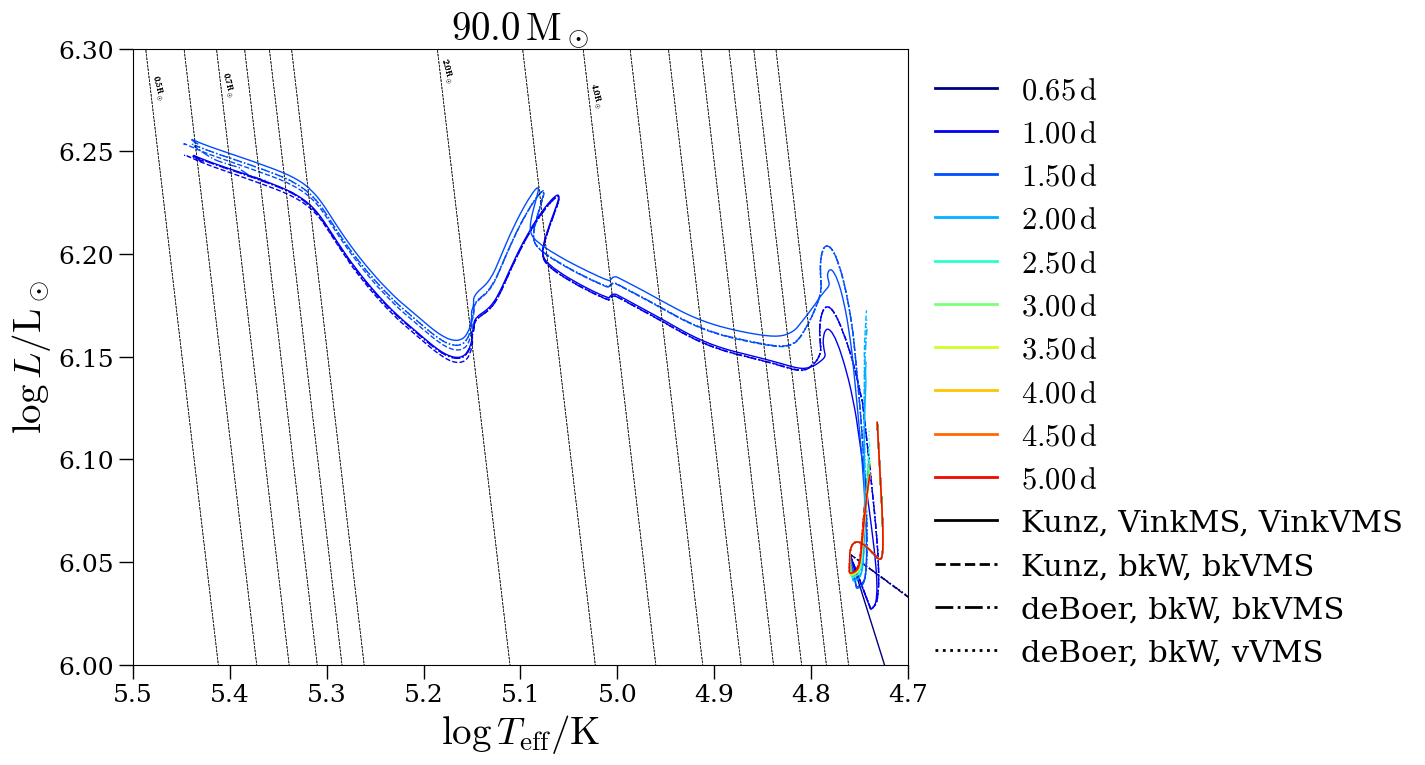

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
test_m = '90.0'

model_dicts = model_dicts_test00_deboer_01zsun_bkW_bkVMS
models_to_plot = [1]
model_style_list = ['-.']
xlim = (5.5, 4.7)
ylim = (6, 6.3)
legend = False
labelx = True
labely = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test01_deboer_01zsun_bkW_vVMS
model_style_list = [':']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test02_kunz_01zsun_bkW_bkVMS
model_style_list = ['--']

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test08_kunz_01zsun_vW_vVMS
model_style_list = ['-']
legend = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

handles.append(Line2D([], [], c='k', ls='-', label='Kunz, VinkMS, VinkVMS'))
handles.append(Line2D([], [], c='k', ls='--', label='Kunz, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls='-.', label='deBoer, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls=':', label='deBoer, bkW, vVMS'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

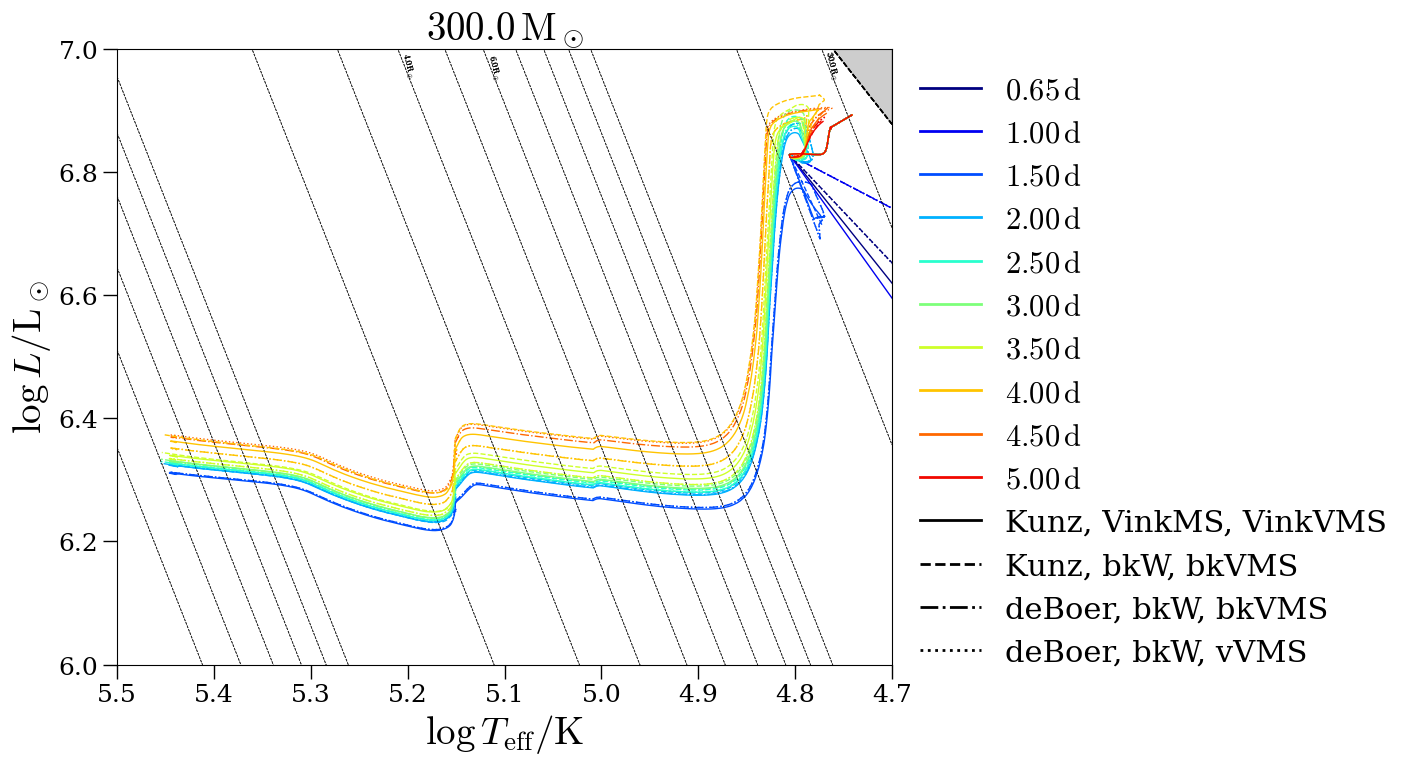

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
test_m = '300.0'

model_dicts = model_dicts_test00_deboer_01zsun_bkW_bkVMS
models_to_plot = [2]
model_style_list = ['-.']
xlim = (5.5, 4.7)
ylim = (6, 7)
legend = False
labelx = True
labely = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test01_deboer_01zsun_bkW_vVMS
model_style_list = [':']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test02_kunz_01zsun_bkW_bkVMS
model_style_list = ['--']

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test08_kunz_01zsun_vW_vVMS
model_style_list = ['-']
legend = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

handles.append(Line2D([], [], c='k', ls='-', label='Kunz, VinkMS, VinkVMS'))
handles.append(Line2D([], [], c='k', ls='--', label='Kunz, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls='-.', label='deBoer, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls=':', label='deBoer, bkW, vVMS'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

In [33]:
m = '40.0'
print(f'Final masses for m0={m}')

print('test00_deboer_01zsun_bkW_bkVMS')
model_dicts = model_dicts_test00_deboer_01zsun_bkW_bkVMS[0][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test01_deboer_01zsun_bkW_vVMS')
model_dicts = model_dicts_test01_deboer_01zsun_bkW_vVMS[0][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test02_kunz_01zsun_bkW_bkVMS')
model_dicts = model_dicts_test02_kunz_01zsun_bkW_bkVMS[0][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test08_kunz_01zsun_vW_vVMS')
model_dicts = model_dicts_test08_kunz_01zsun_vW_vVMS[0][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

Final masses for m0=40.0
test00_deboer_01zsun_bkW_bkVMS
0.65 29.11486222899856
1.00 39.86104778270637
1.50 39.93719981532151
2.00 39.93982059527586
2.50 39.93902304441712
3.00 39.93987227005911
3.50 39.94057849094973
4.00 39.940903720310516
4.50 39.941158934264635
5.00 39.9413710608821

test01_deboer_01zsun_bkW_vVMS
0.65 29.118346967571338
1.00 39.86104778270637
1.50 39.93719981532151
2.00 39.93982059527586
2.50 39.93902304441712
3.00 39.93987227005911
3.50 39.94057849094973
4.00 39.940903720310516
4.50 39.94115895679249
5.00 39.9413710608821

test02_kunz_01zsun_bkW_bkVMS
0.65 29.053895083713073
1.00 39.85442151886498
1.50 39.93693791387563
2.00 39.9400098863847
2.50 39.93924823354045
3.00 39.93987393187662
3.50 39.94057848174033
4.00 39.94090373421369
4.50 39.94115897402052
5.00 39.94137104526021

test08_kunz_01zsun_vW_vVMS
0.65 28.637833245150667
1.00 39.52868872550043
1.50 39.73844794609204
2.00 39.754385463796275
2.50 39.761808636969185
3.00 39.76487825019773
3.50 39.76852598614337

In [34]:
mi = 1
m = '90.0'
print(f'Final masses for m0={m}')

print('test00_deboer_01zsun_bkW_bkVMS')
model_dicts = model_dicts_test00_deboer_01zsun_bkW_bkVMS[mi][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test01_deboer_01zsun_bkW_vVMS')
model_dicts = model_dicts_test01_deboer_01zsun_bkW_vVMS[mi][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test02_kunz_01zsun_bkW_bkVMS')
model_dicts = model_dicts_test02_kunz_01zsun_bkW_bkVMS[mi][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test08_kunz_01zsun_vW_vVMS')
model_dicts = model_dicts_test08_kunz_01zsun_vW_vVMS[mi][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

Final masses for m0=90.0
test00_deboer_01zsun_bkW_bkVMS
0.65 89.99033095004562
1.00 34.05116180115075
1.50 34.407384590943145
2.00 89.4626872777515
2.50 89.72752509780342
3.00 89.7537295422619
3.50 89.7658549937295
4.00 89.77288670489644
4.50 89.77640433097713
5.00 89.77892310156221

test01_deboer_01zsun_bkW_vVMS
0.65 89.99033044124829
1.00 34.050246235473246
1.50 34.407392599906615
2.00 89.44329116888589
2.50 89.71158011239064
3.00 89.75353781498147
3.50 89.7658549937295
4.00 89.77301428605882
4.50 89.7762050594908
5.00 89.77892310156221

test02_kunz_01zsun_bkW_bkVMS
0.65 89.99033095004563
1.00 33.922665919133344
1.50 34.264164527345486
2.00 89.42272096634125
2.50 89.72440027066695
3.00 89.75379156320892
3.50 89.76564147493026
4.00 89.77225645923556
4.50 89.77640025720824
5.00 89.77805274398364

test08_kunz_01zsun_vW_vVMS
0.65 89.95601195785366
1.00 34.07532563620614
1.50 34.545905734068754
2.00 87.46935035090108
2.50 88.64121298148
3.00 88.8153860013268
3.50 88.86612649237739
4.00 88

In [35]:
mi = 2
m = '300.0'
print(f'Final masses for m0={m}')

print('test00_deboer_01zsun_bkW_bkVMS')
model_dicts = model_dicts_test00_deboer_01zsun_bkW_bkVMS[mi][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test01_deboer_01zsun_bkW_vVMS')
model_dicts = model_dicts_test01_deboer_01zsun_bkW_vVMS[mi][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test02_kunz_01zsun_bkW_bkVMS')
model_dicts = model_dicts_test02_kunz_01zsun_bkW_bkVMS[mi][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

print('test08_kunz_01zsun_vW_vVMS')
model_dicts = model_dicts_test08_kunz_01zsun_vW_vVMS[mi][m]
ks = list(model_dicts.keys())
ks = np.array(ks)[np.argsort([float(k) for k in ks])]
for p in ks:
    path = model_dicts[p]
    h = mr.MesaData(str(path/'LOGS/history.data'))
    print(p, h.star_mass[-1])
print('')

Final masses for m0=300.0
test00_deboer_01zsun_bkW_bkVMS
0.65 300.0
1.00 299.8848806511409
1.50 38.30073926241065
2.00 39.1557875877755
2.50 39.33065504811278
3.00 39.537644209521034
3.50 39.85077636654555
4.00 41.10354853522668
4.50 42.47408479729762
5.00 285.7843769236007

test01_deboer_01zsun_bkW_vVMS
0.65 299.9620469498817
1.00 299.88488223905574
1.50 38.30229198936524
2.00 39.15590334270971
2.50 39.3323077503493


3.00 39.53233497591595
3.50 39.858797298956944
4.00 41.11705688337494
4.50 42.729030067118735
5.00 285.540419644325

test02_kunz_01zsun_bkW_bkVMS
0.65 299.96204702625437
1.00 299.8848817410415
1.50 258.3611486894863
2.00 39.0511553600027
2.50 39.24617534214458
3.00 39.50191792099886
3.50 40.284064623695066
4.00 42.47453555294467
4.50 297.1963270320258
5.00 298.0913958549178

test08_kunz_01zsun_vW_vVMS
0.65 299.71634130502497
1.00 299.4523052064772
1.50 38.19990876721758
2.00 39.12010162450283
2.50 39.33438280468003
3.00 39.592431636106255
3.50 40.22996585100737
4.00 41.96499332177884
4.50 284.608929366048
5.00 288.0204526175866



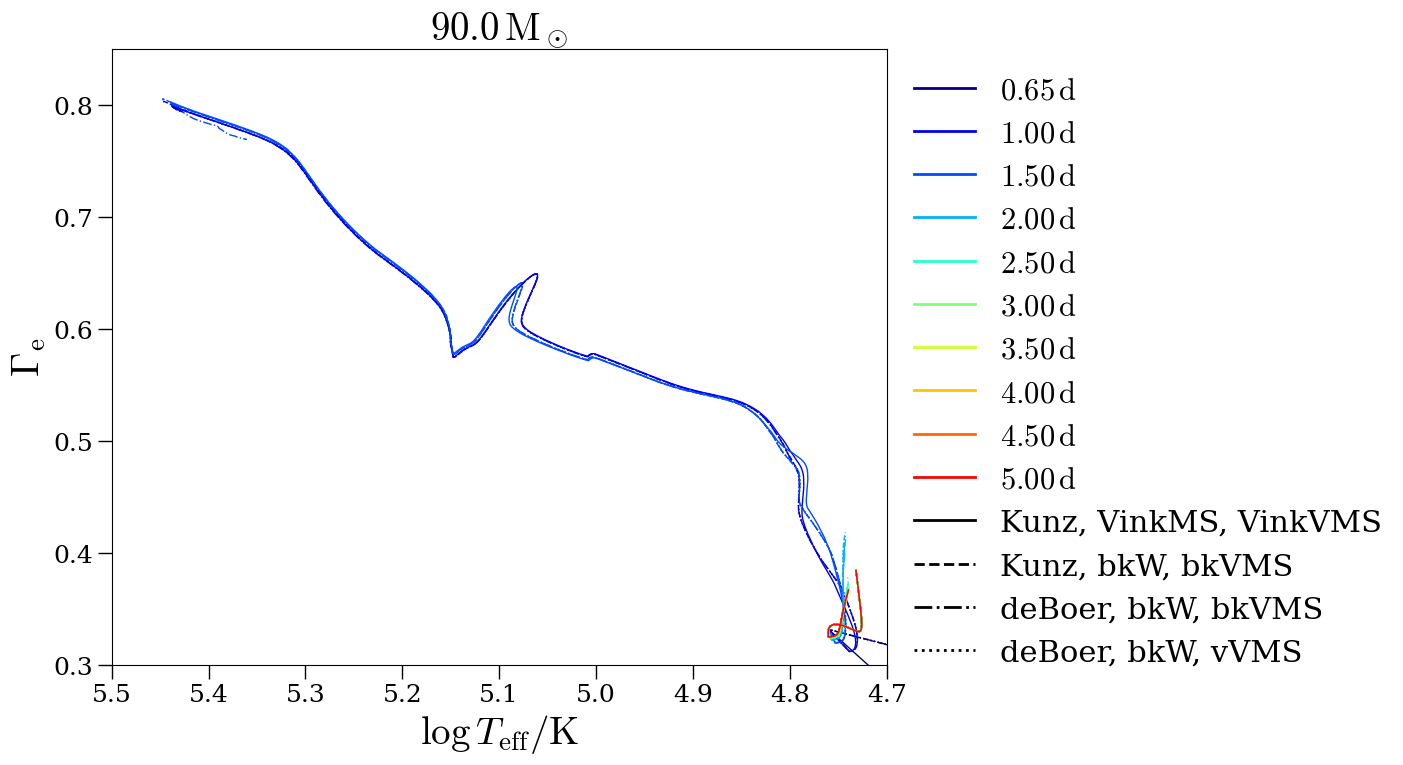

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
test_m = '90.0'

model_dicts = model_dicts_test00_deboer_01zsun_bkW_bkVMS
models_to_plot = [1]
model_style_list = ['-.']
xlim = (5.5, 4.7)
ylim = (0.3, 0.85)
legend = False
labelx = True
labely = True

ax, handles = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test01_deboer_01zsun_bkW_vVMS
model_style_list = [':']
legend = False
labelx = False
labely = False

ax, handles = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test02_kunz_01zsun_bkW_bkVMS
model_style_list = ['--']


ax, handles = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test08_kunz_01zsun_vW_vVMS
model_style_list = ['-']
legend = True

ax, handles = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

handles.append(Line2D([], [], c='k', ls='-', label='Kunz, VinkMS, VinkVMS'))
handles.append(Line2D([], [], c='k', ls='--', label='Kunz, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls='-.', label='deBoer, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls=':', label='deBoer, bkW, vVMS'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

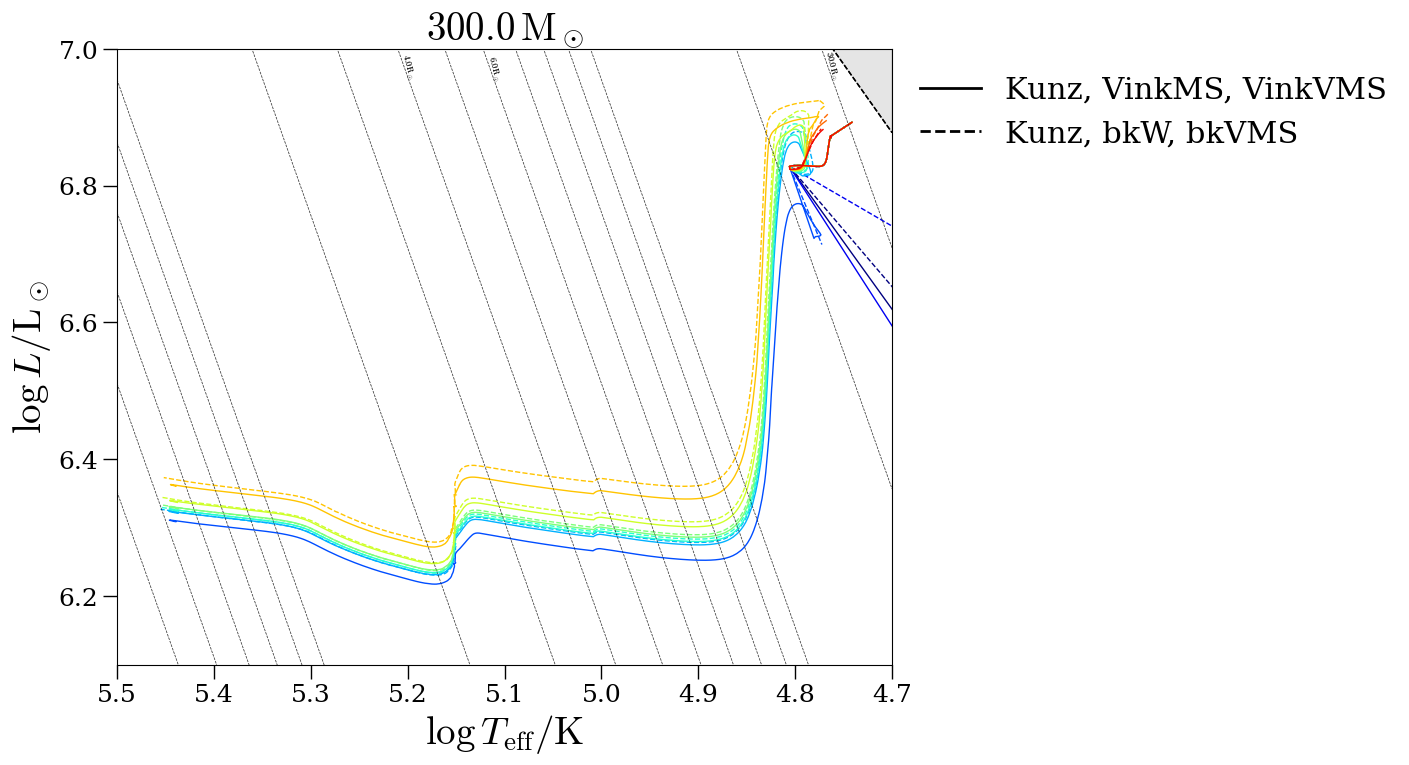

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))
test_m = '300.0'

###

model_dicts = model_dicts_test02_kunz_01zsun_bkW_bkVMS
models_to_plot = [2]
model_style_list = ['--']
xlim = (5.5, 4.7)
ylim = (6.1, 7.0)
legend = False
labelx = True
labely = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test08_kunz_01zsun_vW_vVMS
model_style_list = ['-']
legend = True
labelx = False
labely = False


ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='k', ls='-', label='Kunz, VinkMS, VinkVMS'))
handles.append(Line2D([], [], c='k', ls='--', label='Kunz, bkW, bkVMS'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

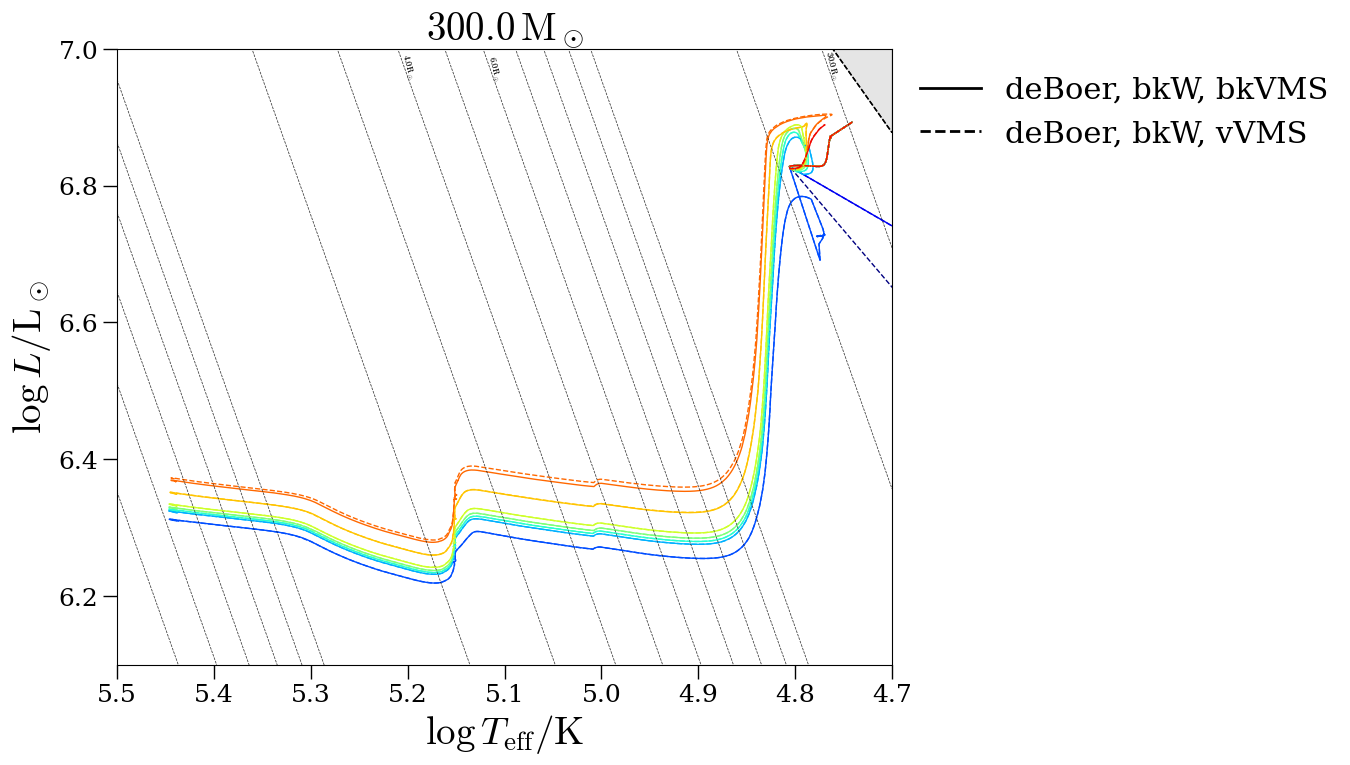

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))
test_m = '300.0'

model_dicts = model_dicts_test00_deboer_01zsun_bkW_bkVMS
models_to_plot = [2]
model_style_list = ['-']
xlim = (5.5, 4.7)
ylim = (6.1, 7.0)
legend = True
labelx = True
labely = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test01_deboer_01zsun_bkW_vVMS
model_style_list = ['--']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')


handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='k', ls='-', label='deBoer, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls='--', label='deBoer, bkW, vVMS'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

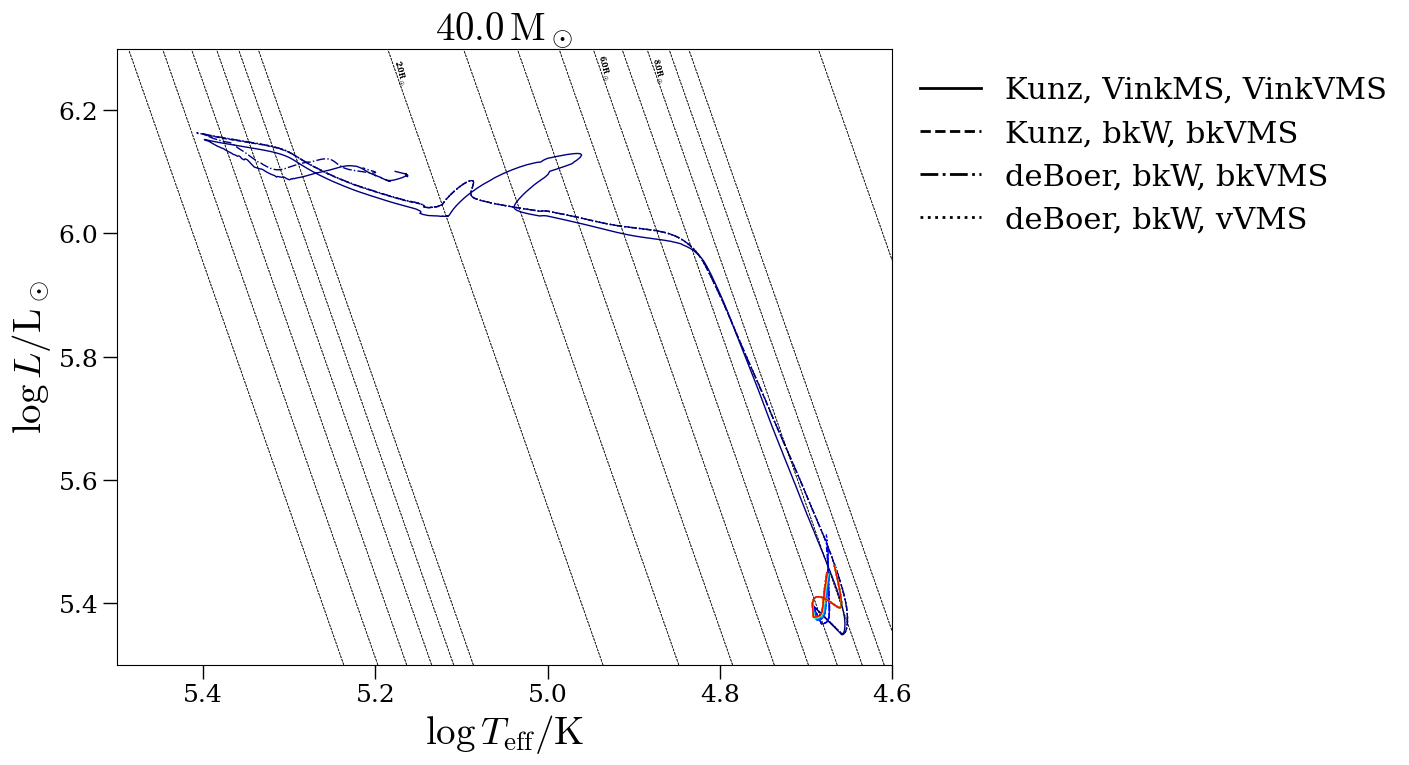

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
test_m = '40.0'

model_dicts = model_dicts_test00_deboer_01zsun_bkW_bkVMS
models_to_plot = [0]
model_style_list = ['-.']
xlim = (5.5, 4.6)
ylim = (5.3, 6.3)
legend = False
labelx = True
labely = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test01_deboer_01zsun_bkW_vVMS
model_style_list = [':']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test02_kunz_01zsun_bkW_bkVMS
model_style_list = ['--']

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

model_dicts = model_dicts_test08_kunz_01zsun_vW_vVMS
model_style_list = ['-']
legend = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

###

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='k', ls='-', label='Kunz, VinkMS, VinkVMS'))
handles.append(Line2D([], [], c='k', ls='--', label='Kunz, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls='-.', label='deBoer, bkW, bkVMS'))
handles.append(Line2D([], [], c='k', ls=':', label='deBoer, bkW, vVMS'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

## Metallicity grid

In [40]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon2/test04_metgrid'

In [41]:
model_ids = np.arange(1, 6, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder/'001_md1_m40_zsundiv10_04y0_03dy') for folder in model_folders])
model_labels = np.array([
    f'${float(folder.name.split("_")[2].rstrip("zsun"))/10:.1f}\\,\\mathrm{{Z}}_\\odot$' for folder in model_folders
])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/001_deboer_01zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/002_deboer_02zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/003_deboer_04zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/004_deboer_08zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/005_deboer_10zsun_bkW_bkVMS


Text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

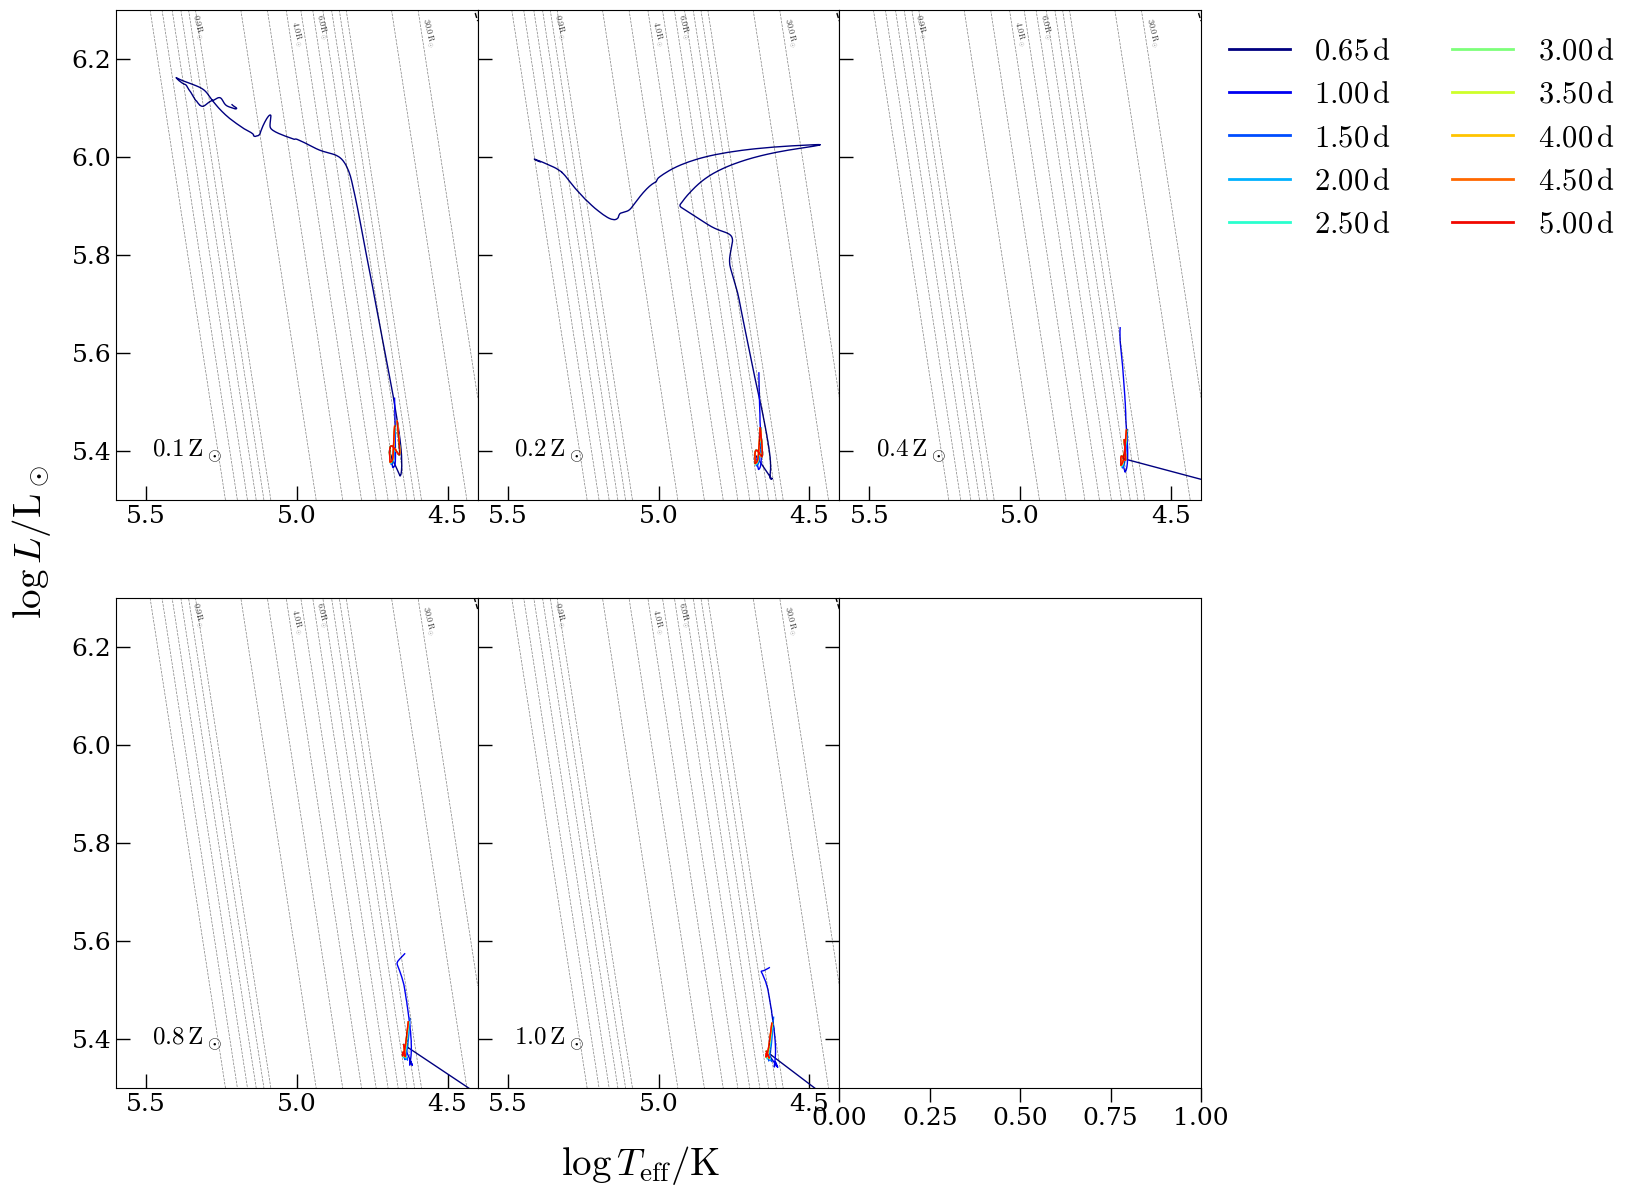

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(14, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.6, 4.4)
ylim = (5.3, 6.3)

for i, (ax, label) in enumerate(zip(axes.flatten(), model_labels)):
    models_to_plot = [i]
    model_style_list = ['-']
       
    if i == 2:
        legend = True
    else:
        legend = False
               
    ax, handles = hr_diagram_tracks(
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)
    
fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

#savefig(fig, 'hr_allp_metallicity_comparison')


In [43]:
model_ids = np.arange(1, 6, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder/'002_md1_m90_zsundiv10_04y0_03dy') for folder in model_folders])
model_labels = np.array([
    f'${float(folder.name.split("_")[2].rstrip("zsun"))/10:.1f}\\,\\mathrm{{Z}}_\\odot$' for folder in model_folders
])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/001_deboer_01zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/002_deboer_02zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/003_deboer_04zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/004_deboer_08zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/005_deboer_10zsun_bkW_bkVMS


Text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

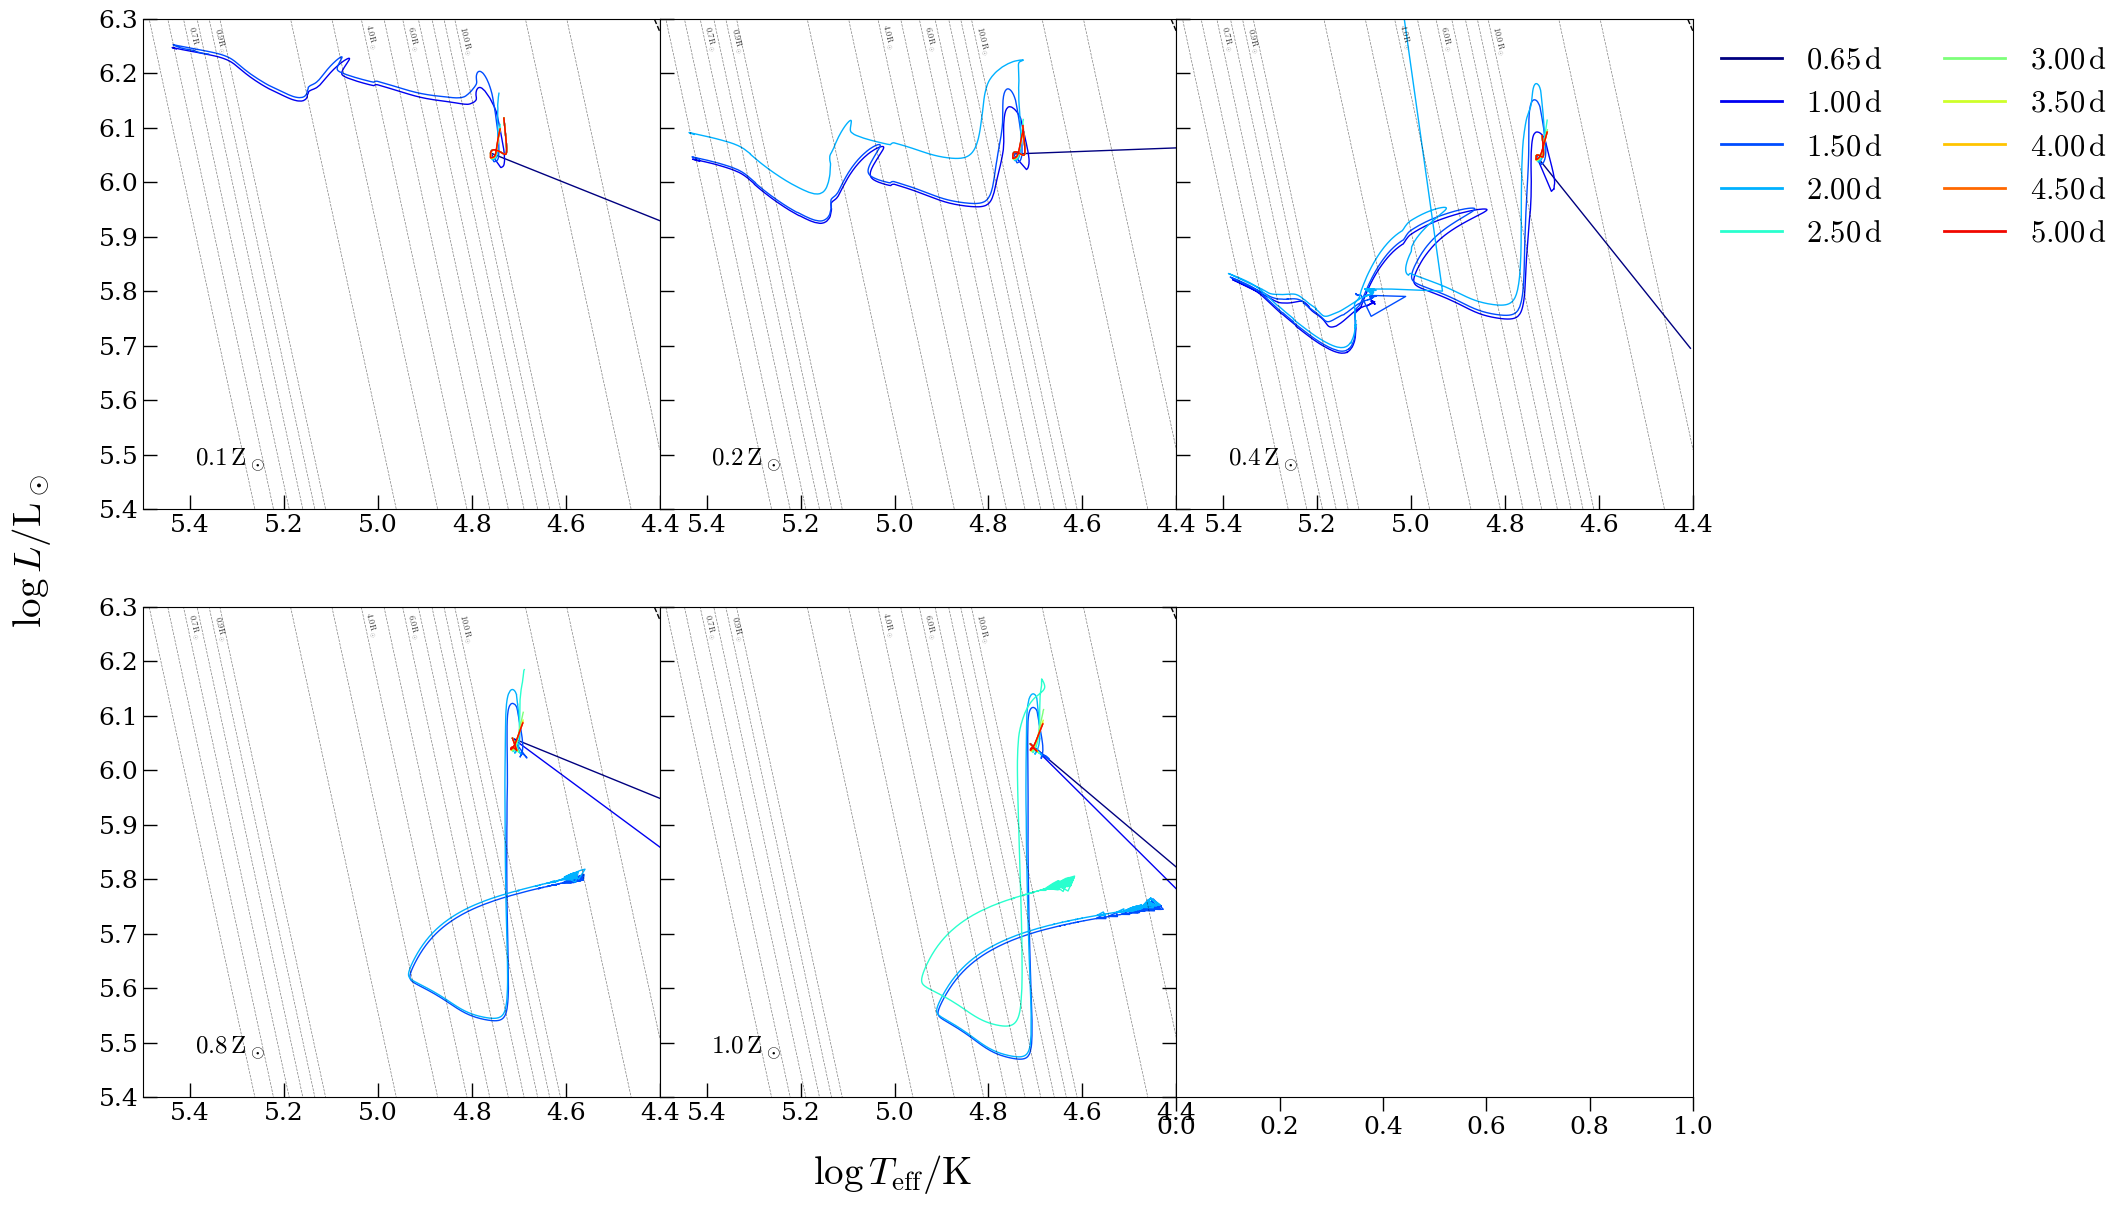

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.4)
ylim = (5.4, 6.3)

for i, (ax, label) in enumerate(zip(axes.flatten(), model_labels)):
    models_to_plot = [i]
    model_style_list = ['-']
       
    if i == 2:
        legend = True
    else:
        legend = False
               
    ax, handles = hr_diagram_tracks(
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)
    
fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

#savefig(fig, 'hr_allp_metallicity_comparison')


In [45]:
model_ids = np.arange(1, 6, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder/'003_md1_m300_zsundiv10_04y0_03dy') for folder in model_folders])
model_labels = np.array([
    f'${float(folder.name.split("_")[2].rstrip("zsun"))/10:.1f}\\,\\mathrm{{Z}}_\\odot$' for folder in model_folders
])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/001_deboer_01zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/002_deboer_02zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/003_deboer_04zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/004_deboer_08zsun_bkW_bkVMS
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test04_metgrid/005_deboer_10zsun_bkW_bkVMS


Text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

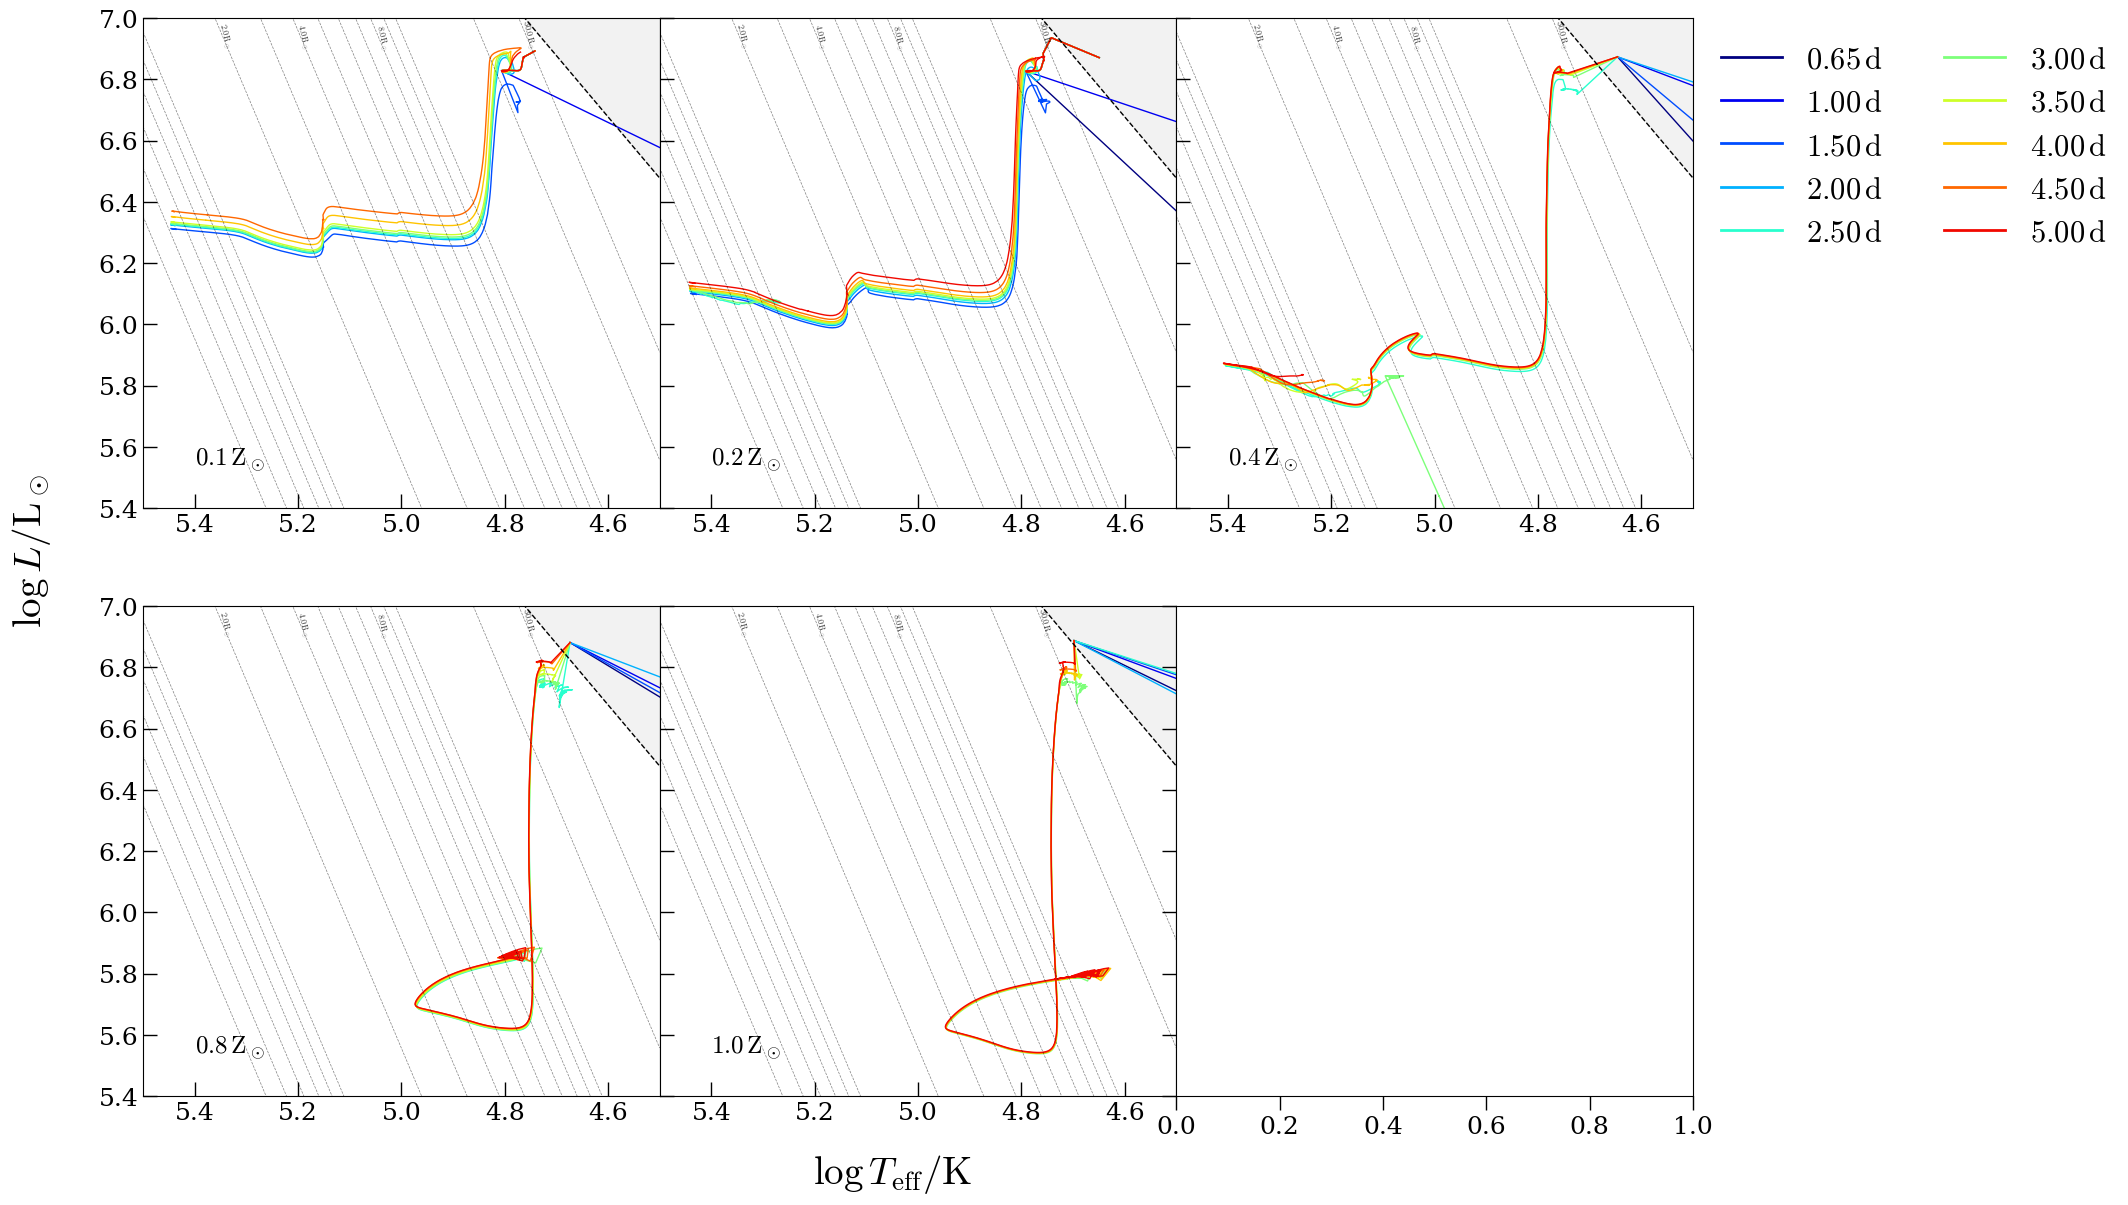

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.5)
ylim = (5.4, 7)

for i, (ax, label) in enumerate(zip(axes.flatten(), model_labels)):
    models_to_plot = [i]
    model_style_list = ['-']
       
    if i == 2:
        legend = True
    else:
        legend = False
               
    ax, handles = hr_diagram_tracks(
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)
    
fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

#savefig(fig, 'hr_allp_metallicity_comparison')


In [47]:
wind_test_h = mr.MesaData(str(model_dicts[0]['300.0']['2.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]
wind_test_omega = wind_test_omega[wind_test_start_i:]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b23_winds = np.array([
    bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k24_winds = np.array([
    krticka2024_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
v01_winds = np.array([
    vink2001_w(l, t, m, z) for l, t, m, z in zip(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
])

fw = Winds(ms_winds='bjorklund+krticka')

full_winds = np.array([
    fw.winds(l, m, t, z, x, ms_winds='bjorklund+krticka') for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]

mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
    

## Superad reduction tests

Below we test the scaling ($\alpha$ and $\beta$) parameters of the superadiabaticity reduction in MESA.

In [48]:
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial_carbon2/test09_superad_red_test'

In [49]:
model_ids = np.arange(1, 5, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder/'001_md1_m40_zsundiv10_04y0_03dy') for folder in model_folders])
model_labels = np.array([
    '$\\alpha=\\beta=6.25$',
    '$\\alpha=\\beta=7.50$',
    '$\\alpha=\\beta=8.75$',
    '$\\alpha=\\beta=10.00$'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/001_deboer_01zsun_bkW_bkVMS_MLT_125scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/002_deboer_01zsun_bkW_bkVMS_MLT_150scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/003_deboer_01zsun_bkW_bkVMS_MLT_175scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/004_deboer_01zsun_bkW_bkVMS_MLT_200scale


Text(0.5, 1.0, '$40\\,\\mathrm{M}_\\odot$')

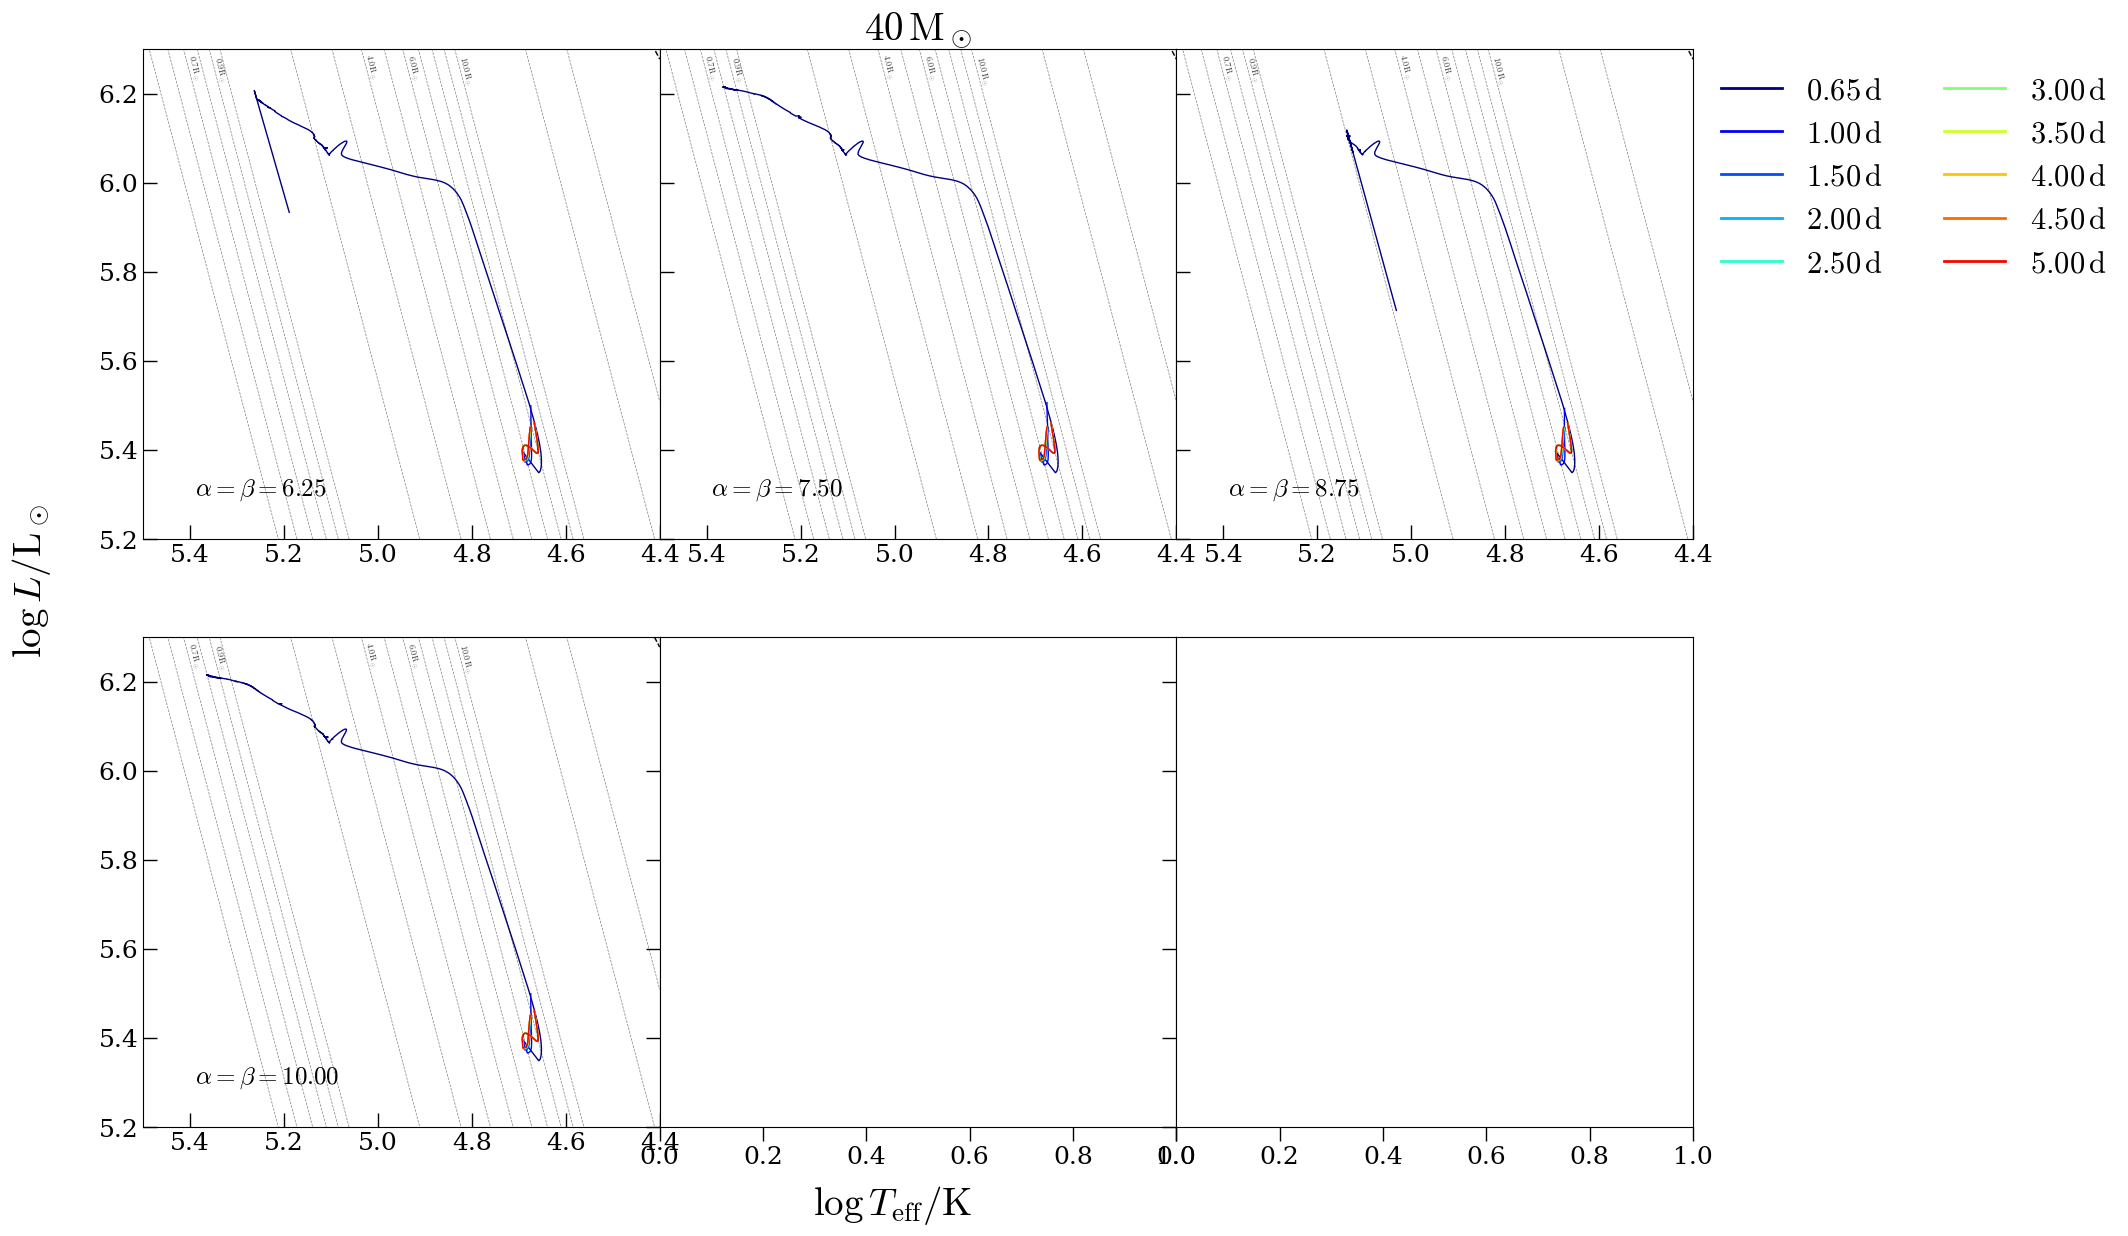

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.4)
ylim = (5.2, 6.3)

for i, (ax, label) in enumerate(zip(axes.flatten(), model_labels)):
    models_to_plot = [i]
    model_style_list = ['-']
       
    if i == 2:
        legend = True
    else:
        legend = False
               
    ax, handles = hr_diagram_tracks(
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)
    
fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
axes[0, 1].set_title('$40\\,\\mathrm{M}_\\odot$')

#savefig(fig, 'hr_allp_metallicity_comparison')


In [51]:
model_ids = np.arange(1, 5, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder/'002_md1_m90_zsundiv10_04y0_03dy') for folder in model_folders])
model_labels = np.array([
    '$\\alpha=\\beta=6.25$',
    '$\\alpha=\\beta=7.50$',
    '$\\alpha=\\beta=8.75$',
    '$\\alpha=\\beta=10.00$'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/001_deboer_01zsun_bkW_bkVMS_MLT_125scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/002_deboer_01zsun_bkW_bkVMS_MLT_150scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/003_deboer_01zsun_bkW_bkVMS_MLT_175scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/004_deboer_01zsun_bkW_bkVMS_MLT_200scale


Text(0.5, 1.0, '$90\\,\\mathrm{M}_\\odot$')

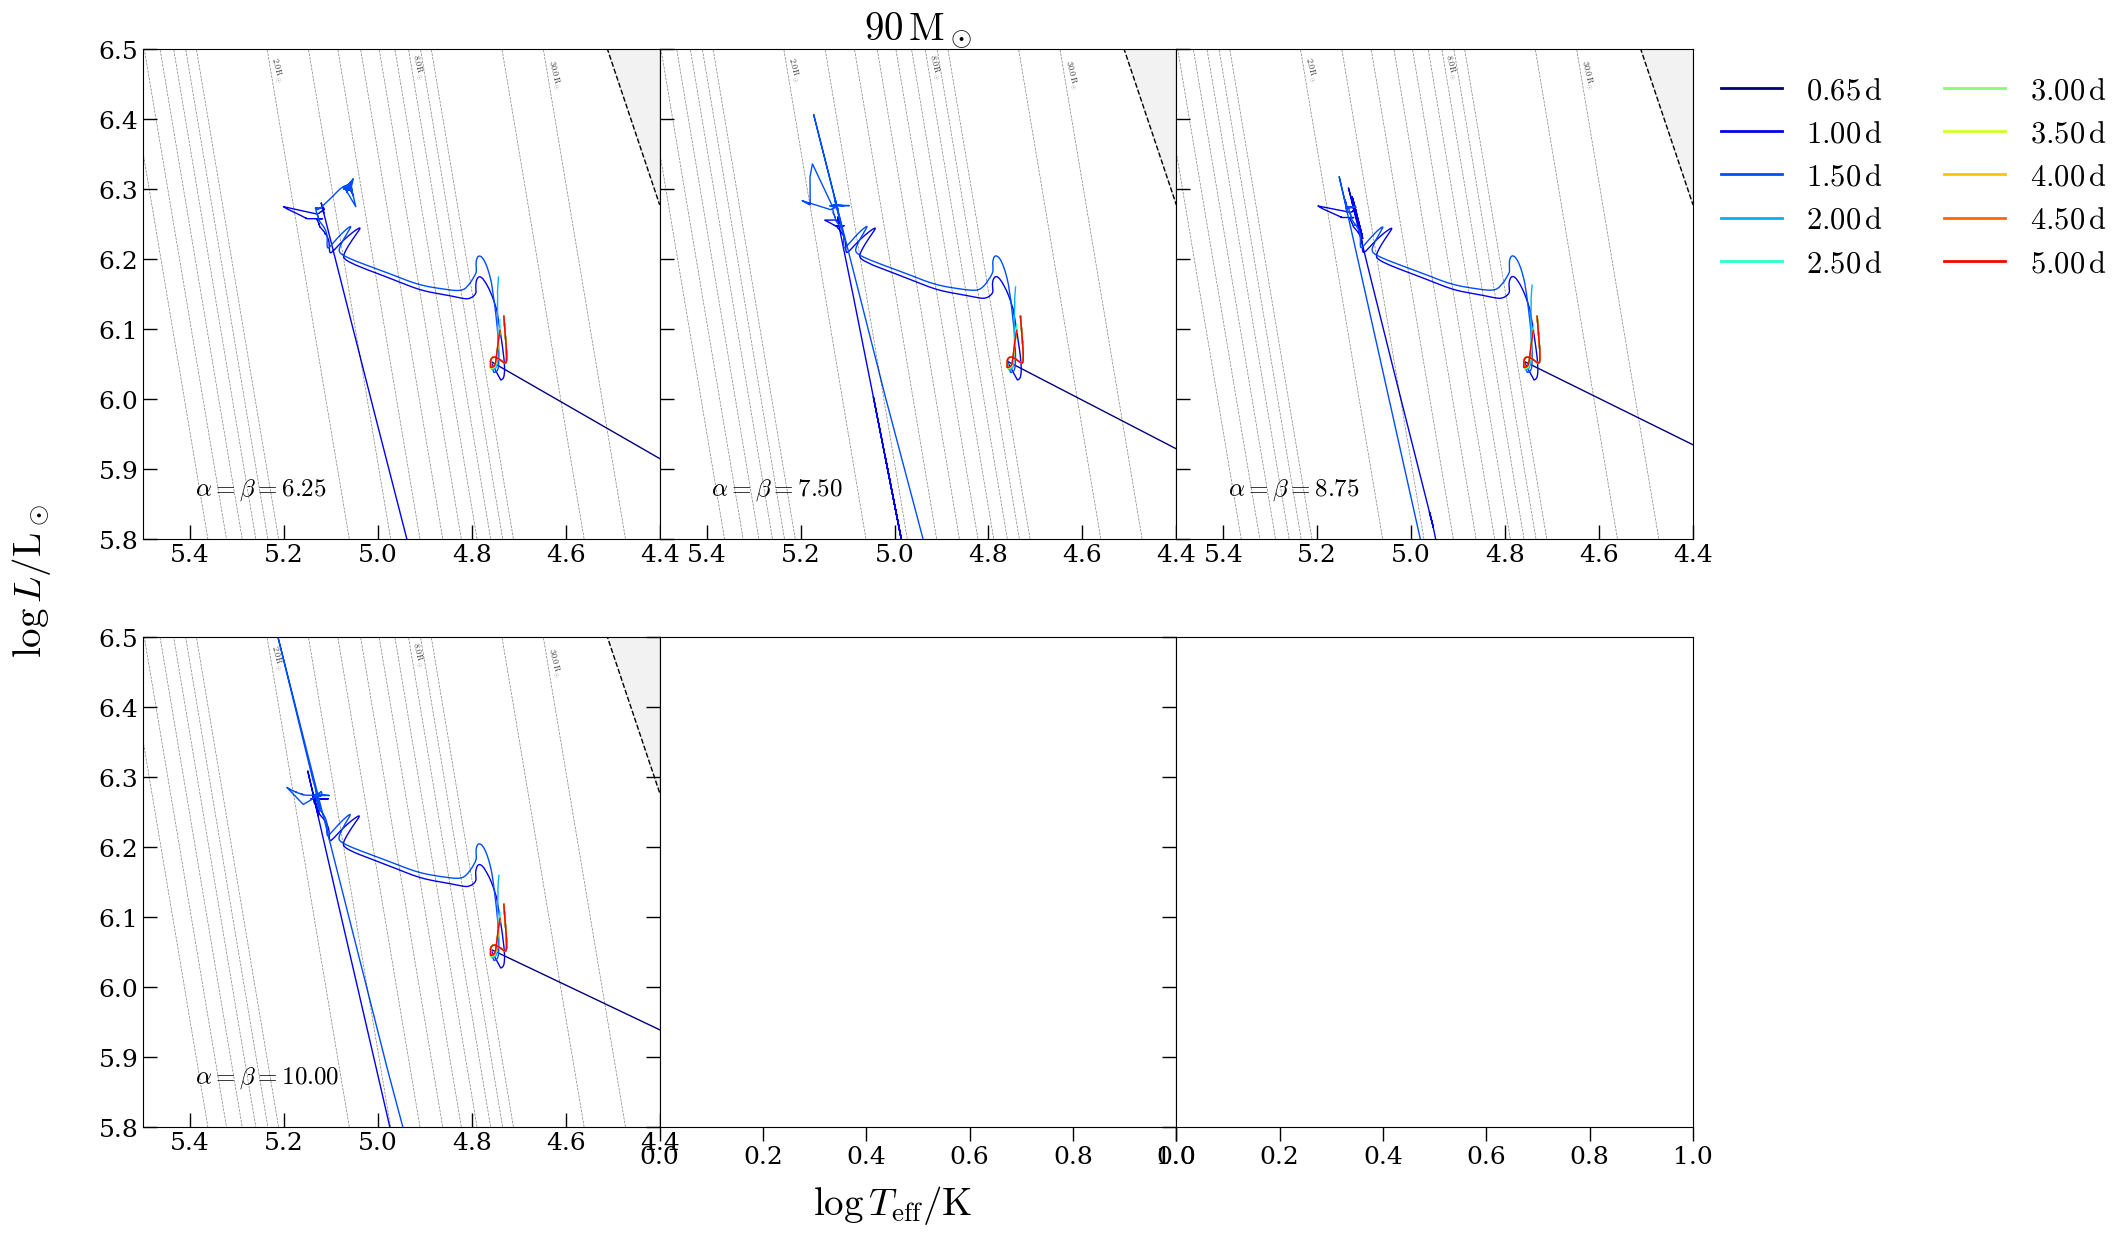

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.4)
ylim = (5.8, 6.5)

for i, (ax, label) in enumerate(zip(axes.flatten(), model_labels)):
    models_to_plot = [i]
    model_style_list = ['-']
       
    if i == 2:
        legend = True
    else:
        legend = False
               
    ax, handles = hr_diagram_tracks(
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)
    
fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
axes[0, 1].set_title('$90\\,\\mathrm{M}_\\odot$')

#savefig(fig, 'hr_allp_metallicity_comparison')


In [52]:
model_ids = np.arange(1, 5, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder/'003_md1_m300_zsundiv10_04y0_03dy') for folder in model_folders])
model_labels = np.array([
    '$\\alpha=\\beta=6.25$',
    '$\\alpha=\\beta=7.50$',
    '$\\alpha=\\beta=8.75$',
    '$\\alpha=\\beta=10.00$'])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/001_deboer_01zsun_bkW_bkVMS_MLT_125scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/002_deboer_01zsun_bkW_bkVMS_MLT_150scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/003_deboer_01zsun_bkW_bkVMS_MLT_175scale
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial_carbon2/test09_superad_red_test/004_deboer_01zsun_bkW_bkVMS_MLT_200scale


Text(0.5, 1.0, '$300\\,\\mathrm{M}_\\odot$')

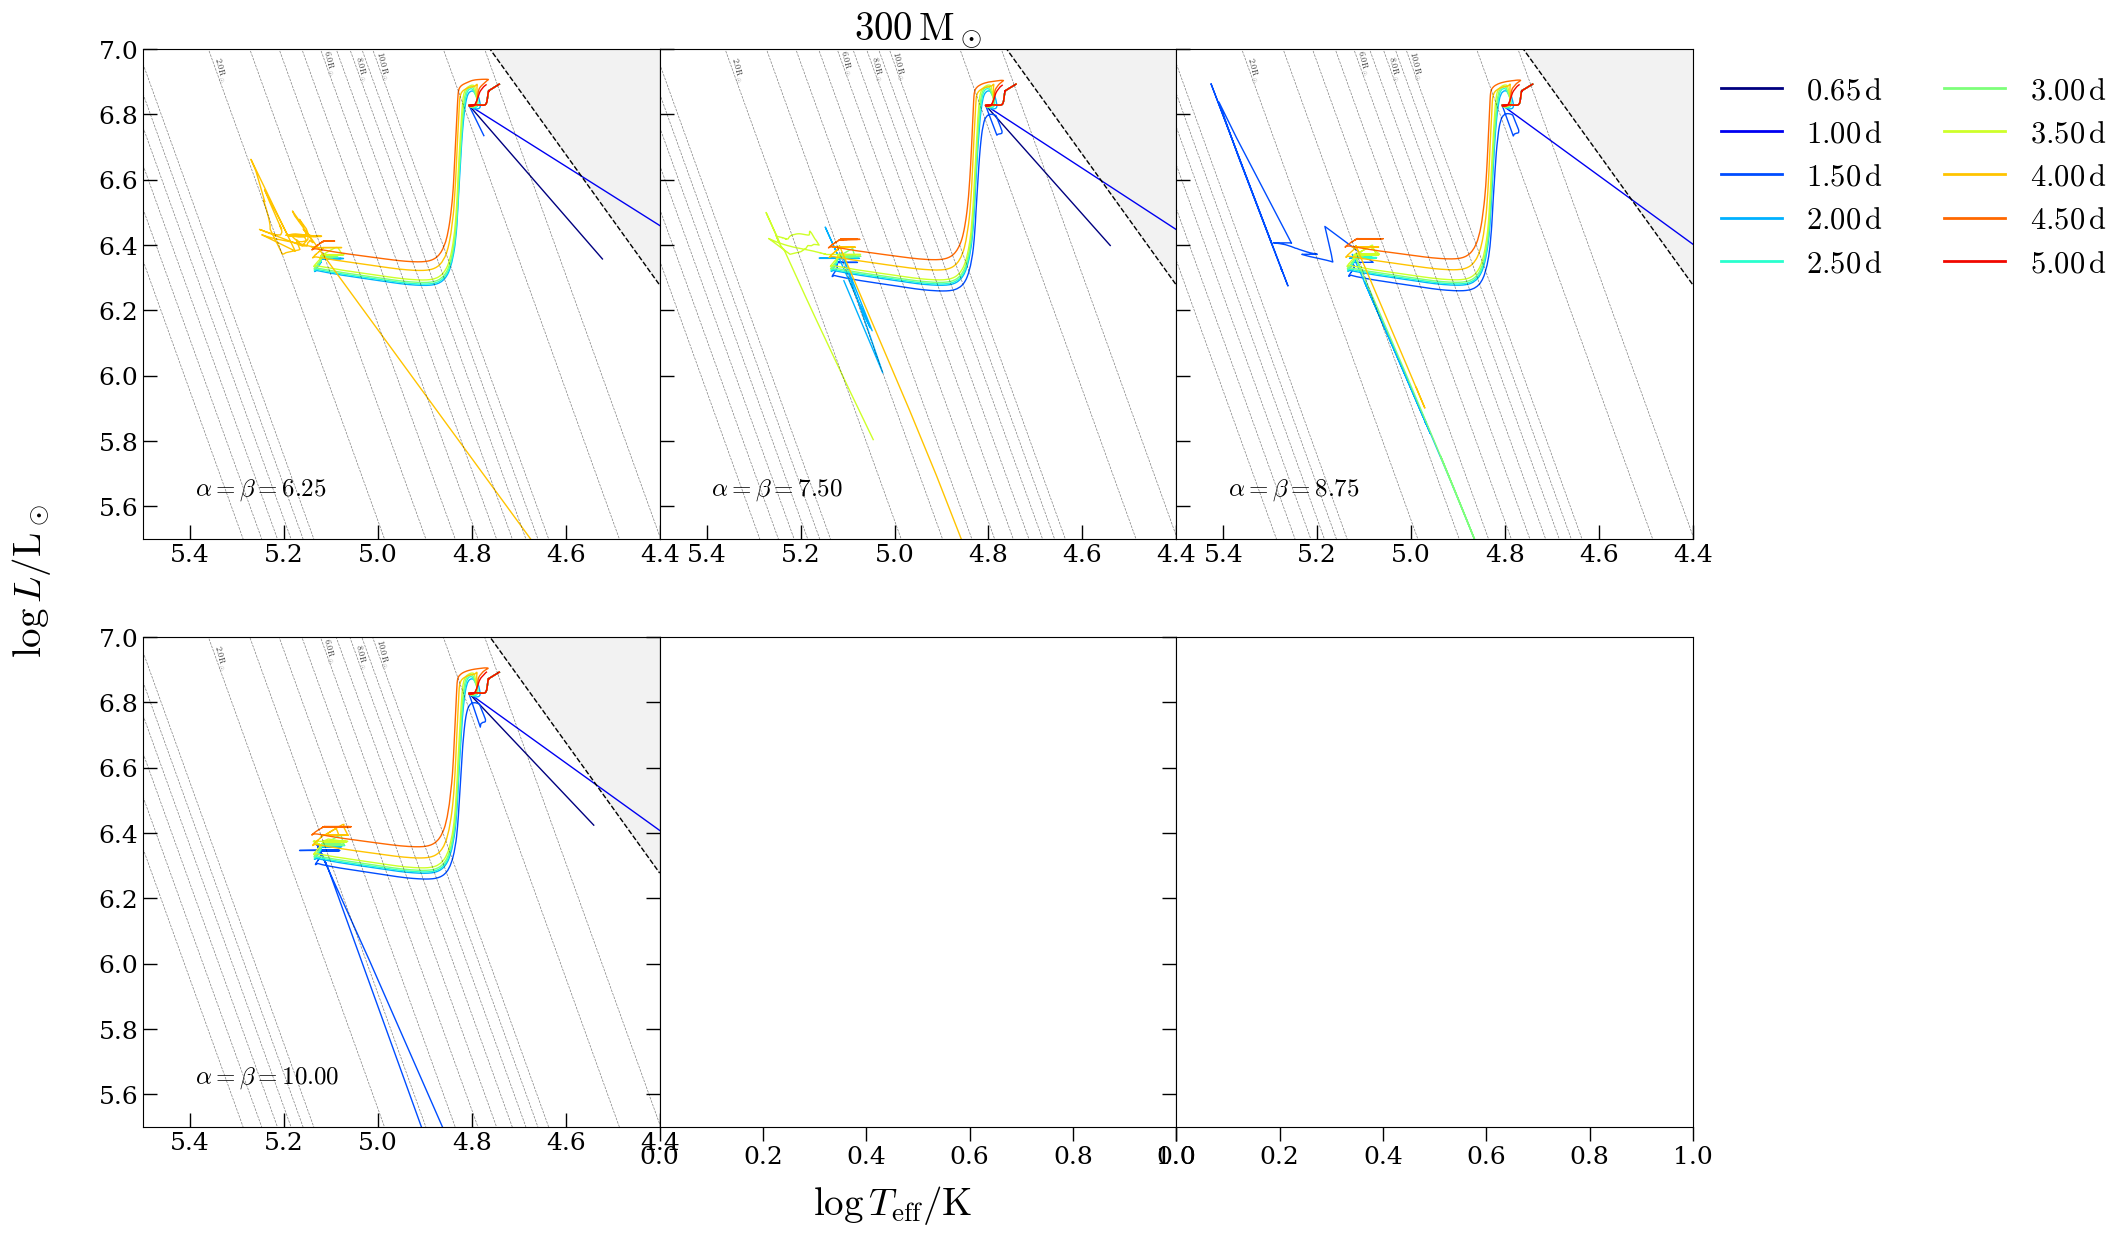

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.4)
ylim = (5.5, 7.0)

for i, (ax, label) in enumerate(zip(axes.flatten(), model_labels)):
    models_to_plot = [i]
    model_style_list = ['-']
       
    if i == 2:
        legend = True
    else:
        legend = False
               
    ax, handles = hr_diagram_tracks(
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)
    
fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
axes[0, 1].set_title('$300\\,\\mathrm{M}_\\odot$')

#savefig(fig, 'hr_allp_metallicity_comparison')


## More metallicity tests

In [29]:
PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept'

In [38]:
PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_02zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_04zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
#model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
#model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

#model_dicts_06zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_08zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_10zsun = model_dicts

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/002_md1_m30_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/003_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/004_md1_m50_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/005_md1_m60_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/006_md1_m70_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/007_md1_m80_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


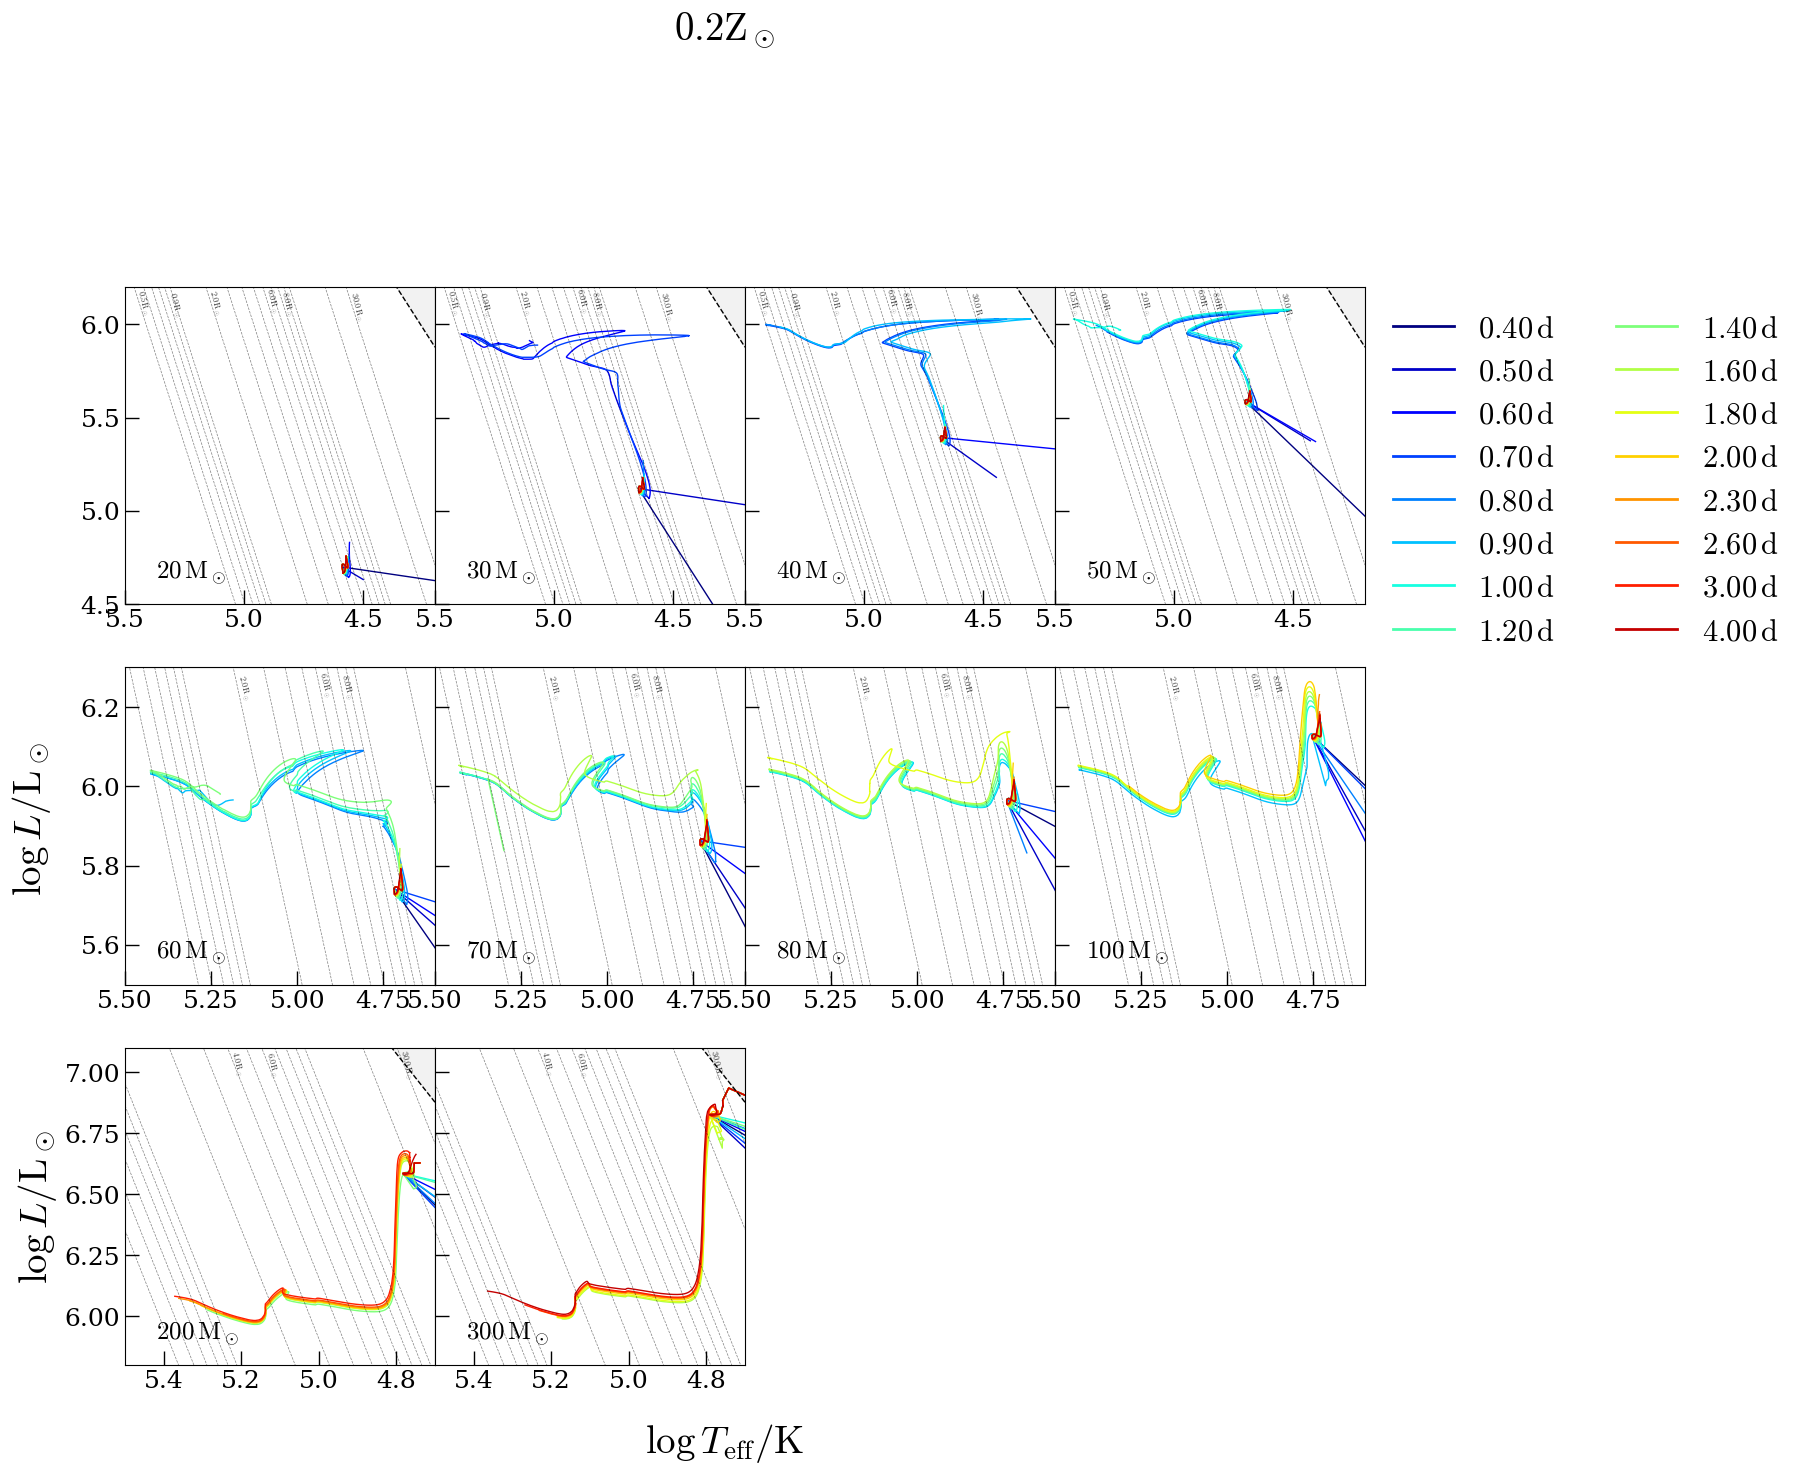

In [41]:
fig, axes = plt.subplots(3, 4, figsize=(16, 14))
fig.subplots_adjust(wspace=0)

model_dicts = model_dicts_02zsun

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

xlim = (5.5, 4.2)
ylim = (4.5, 6.2)

# PLOT M=20
ax = axes[0, 0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=30
ax = axes[0, 1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=40
ax = axes[0, 2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=50
ax = axes[0, 3]
models_to_plot = [3]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5.5, 4.6)
ylim = (5.5, 6.3)

# PLOT M=60
ax = axes[1, 0]
models_to_plot = [4]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)



# PLOT M=70
ax = axes[1, 1]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=80
ax = axes[1, 2]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=100
ax = axes[1, 3]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)


xlim = (5.5, 4.7)
ylim = (5.8, 7.1)

# PLOT M=200
ax = axes[2, 0]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = True

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=300
ax = axes[2, 1]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

axes[2, 2].axis('off')
axes[2, 3].axis('off')


#######################################

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
fig.text(0.5, 0.9, '$0.2\\mathrm{Z}_\\odot$', va='bottom', ha='center')

savefig(fig, 'hr_allp_mass_comparison_new')